# emotional tts quick c1 iteration

## Preparing EmotionalTTS dataset

In [ ]:
# downloading the datasets

# !(mkdir /DataEmotionalTTS && \

!(cd /DataEmotionalTTS && \
    wget https://www.openslr.org/resources/110/thorsten-emotional_v02.tgz && \
    tar -zxvf thorsten-emotional_v02.tgz)

In [ ]:
# create manifests, normalization and phonemization

# !(cd NeMoEmotionalTTS && \
#     python get_data.py \

!(python scripts/dataset_processing/tts/openslr_emotional/get_data.py \
        --data-root ../DataEmotionalTTS/ \
        --val-size 0.1 \
        --test-size 0.2)

In [ ]:
# 2cc2cc4a34b961ef1657cc82dbd18875 does not exist for whisper category

In [ ]:
# phonemization
## inside the phonemizer container

from phonemizer.backend import EspeakBackend
import json

backend = EspeakBackend('de')
unique_symbols = set()
input_manifest_filepaths = ["/DataEmotionalTTS/thorsten-emotional_v02/train_manifest", \
                            "/DataEmotionalTTS/thorsten-emotional_v02/test_manifest", \
                            "/DataEmotionalTTS/thorsten-emotional_v02/val_manifest"]

for input_manifest_filepath in input_manifest_filepaths:
    output_manifest_filepath = input_manifest_filepath+"_phonemes"
    records = []
    n_text = []
    with open(input_manifest_filepath + ".json", "r") as f:
        for i, line in enumerate(f):
            d = json.loads(line)
            records.append(d)
            n_text.append(d['normalized_text'])

    phonemized = backend.phonemize(n_text)
    for line in n_text:
        for char in line:
            unique_symbols.add(char)
    new_records = []
    for i in range(len(records)):
        records[i]["is_phoneme"] = 0
        new_records.append(records[i])
        phoneme_record = records[i].copy()
        phoneme_record["normalized_text"] = phonemized[i]
        phoneme_record["is_phoneme"] = 1
        new_records.append(phoneme_record)

    with open(output_manifest_filepath + ".json", "w") as f:
        for r in new_records:
            f.write(json.dumps(r) + '\n')
print(unique_symbols)

In [ ]:
a = ''.join(unique_symbols)

In [ ]:
a = a.lower()

In [ ]:
[char for char in a if char not in "ʊʃŋɜːɛɾəɪçɔøɡœɑÜ„1Q̃ɒʒÄɹÖʌθàó̈ðéɐáabcdefghijklmnopqrstuvwxyzäöüß"]

In [ ]:
!ls /DataEmotionalTTS/thorsten-emotional_v02

In [ ]:
# dataset config
!cat scripts/dataset_processing/tts/openslr_emotional/ds_conf/ds_for_fastpitch_align.yaml

In [ ]:
# supplementary data creation - emotional TTS (optional)
!(HYDRA_FULL_ERROR=1 python scripts/dataset_processing/tts/extract_sup_data.py \
        --config-path /NeMoEmotionalTTS/scripts/dataset_processing/tts/openslr_emotional/ds_conf \
        --config-name ds_for_fastpitch_align.yaml \
        manifest_filepath=/DataEmotionalTTS/thorsten-emotional_v02/train_manifest_phonemes.json \
        sup_data_path=/DataEmotionalTTS/thorsten-emotional_v02/phonemes/)

In [ ]:
# PITCH_MEAN=169.59390258789062, PITCH_STD=103.64842224121094
# PITCH_MIN=65.4063949584961, PITCH_MAX=2093.004638671875

## Preparing NeutralTTS dataset

In [ ]:
# edit the manifest files
## path corrections :%s/github\/datasets/DataEmotionalTTS/g
## add emotion_id =0 :%s/, "is_p/, "emotion_id": 0, "is_p/g

In [ ]:
# supplementary data creation - Neutral TTS (optional)
!(HYDRA_FULL_ERROR=1 PYTHONPATH=. python scripts/dataset_processing/tts/extract_sup_data.py \
        --config-path /NeMoEmotionalTTS/scripts/dataset_processing/tts/openslr/ds_conf \
        --config-name ds_for_fastpitch_align.yaml \
        manifest_filepath=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/train_manifest_phonemes.json \
        sup_data_path=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/phonemes6/)

In [ ]:
# PITCH_MEAN=132.55270385742188, PITCH_STD=37.61381912231445
# PITCH_MIN=65.4063949584961, PITCH_MAX=2093.004638671875

In [ ]:
# pre-train fastpitch (with speaker and emotional embedding) on German neutral tts
!(CUDA_VISIBLE_DEVICES=0 HYDRA_FULL_ERROR=1 PYTHONPATH=. python examples/tts/fastpitch.py --config-path conf/de --config-name fastpitch_align_22050 \
    name="c1e1-FastPitch-pretrain" \
    model.train_ds.dataloader_params.batch_size=32 \
    model.validation_ds.dataloader_params.batch_size=32 \
    train_dataset=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/train_manifest_phonemes.json \
    validation_datasets=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/val_manifest_phonemes.json \
    sup_data_path=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/phonemes6/ \
    whitelist_path=nemo_text_processing/text_normalization/de/data/whitelist.tsv \
    exp_manager.exp_dir=/resultEmotionalTTS \
    trainer.max_epochs=100 \
    pitch_mean=132.524658203125 \
    pitch_std=37.389366149902344 \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name="072720221625_c1e1-FastPitch-pretrain" \
    +exp_manager.wandb_logger_kwargs.project="EmotionalTTS" 2>&1 | tee -a 072720221625_c1e1-FastPitch-pretrain.log)

In [10]:
# monitor performance of pre-trained fastpitch
fastpitch_test_path = "/DataEmotionalTTS/staging-c1e1-FastPitch-pretrain/ngc/c1e1-FastPitch-pretrain--v_loss=0.6675-epoch=999-last.ckpt"

In [11]:
!ls /DataEmotionalTTS/staging-c1e1-FastPitch-pretrain/local

'c1e1-FastPitch-pretrain--v_loss=0.6633-epoch=99-last.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6633-epoch=99.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6680-epoch=94.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6719-epoch=89.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6727-epoch=79.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6727-epoch=84.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6775-epoch=74.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6848-epoch=64.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6855-epoch=69.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6917-epoch=59.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.6928-epoch=54.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.7410-epoch=29-last.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.7410-epoch=29.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.7721-epoch=24.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.7913-epoch=19.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.8433-epoch=14.ckpt'
'c1e1-FastPitch-pretrain--v_loss=0.9519-epoch=9.ckpt'
'c1e1-FastPitch-pretrain--v_loss=1.3092-epoch=4.ckpt'
 c

In [12]:
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import torch
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
seed=100
test = "Man darf sich nicht von anderen entmutigen lassen."
test_id = "2edfc39c95ef247c6e39c929d122f4cc"
data_path="/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/wavs/"

# 2 train samples
# test = "Das Hotel konnte keine Rechnung ausstellen."
# test_id = "b6dade90f15f80ba638036432235769c"

# test = "Das Kind hat neununddrei\u00dfig Komma acht Grad Fieber."
# test_id = "cdedc8011ff030d1b1159d25ef977c7b"

# 2 test samples
# test = "Einer geht noch."
# test_id = "e1509ecf93c001510e0c0c985d221973"

# test = "Dieser Pilz ist zwar nicht giftig, aber ungenie\u00dfbar."
# test_id = "b1e9265fcc34a4d3691eb2c6921198a2"

# 2 val samples
# test = "Auch mutige Menschen haben Angst."
# test_id = "0e14b2f2352b602483b5e7d107a07040"

# test = "Dabei ist zu beachten, dass Babys sogar bis zu drei\u00dfig Kilohertz h\u00f6ren k\u00f6nnen."
# test_id = "c784aa96ffceae0259cccc05a7b34bd4"


In [14]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size()) # debug
    #     audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram, sigma=0.8, denoise=True)
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [15]:
v110_fp_path="/DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_fastpitch_align.nemo"
v110_hfg_path="/DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_hifigan.nemo"

In [16]:
# v110_fp = FastPitchModel.restore_from(v110_fp_path).eval().cuda()
v110_hfg = HifiGanModel.restore_from(v110_hfg_path).eval().cuda()
fastpitch_test = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_test_path).eval().cuda()

[NeMo W 2022-08-03 03:17:46 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/synmels_r5_999/hifigan_train_phonemes_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 0
    
[NeMo W 2022-08-03 03:17:46 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collection

[NeMo I 2022-08-03 03:17:46 features:200] PADDING: 0
[NeMo I 2022-08-03 03:17:46 features:208] STFT using exact pad
[NeMo I 2022-08-03 03:17:46 features:200] PADDING: 0
[NeMo I 2022-08-03 03:17:46 features:208] STFT using exact pad
[NeMo I 2022-08-03 03:17:47 save_restore_connector:243] Model HifiGanModel was successfully restored from /DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_hifigan.nemo.
[NeMo I 2022-08-03 03:17:49 tokenize_and_classify:81] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-08-03 03:18:05 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/train_manifest_phonemes.json
      sample_rate: 22050
      sup_data_path: /DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/phonemes6/
      sup_data_types:
      - align_prior_matrix
      - pitch
      - emotion_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004638671875
      pitch_norm: true
      pitch_mean: 132.524658203125
      pitch_std: 37.389366149

[NeMo I 2022-08-03 03:18:05 features:200] PADDING: 1


In [17]:
# %matplotlib inline

# print("v110 produced voice")
# audio, spectrogram = evaluate_spec_fastpitch_ckpt(v110_fp, v110_hfg, test)

# # visualize the spectrogram
# if spectrogram is not None:
#     imshow(spectrogram, origin="lower")
#     plt.show()

# # audio
# print("original audio")
# ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
# print("predicted audio")
# ipd.display(ipd.Audio(audio, rate=22050))

current c1e1 produced voice with v110 hfg
torch.Size([1, 80, 187])


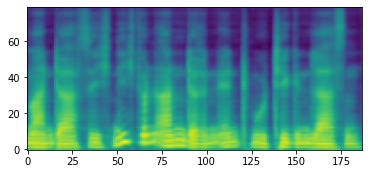

original audio


predicted audio


In [18]:
%matplotlib inline

print("current c1e1 produced voice with v110 hfg")
audio, spectrogram = evaluate_spec_fastpitch_ckpt(fastpitch_test, v110_hfg, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

## Finetune the model on emotional TTS dataset

In [ ]:
# finetune the model trained in the last cell
!(CUDA_VISIBLE_DEVICES=0 python examples/tts/fastpitch_finetune.py --config-path conf/de --config-name fastpitch_align_v1.05.yaml \
    name="c1e1-FastPitch-finetune" \
    model.train_ds.dataloader_params.batch_size=32 \
    model.validation_ds.dataloader_params.batch_size=32 \
    train_dataset=/DataEmotionalTTS/thorsten-emotional_v02/train_manifest_phonemes.json \
    validation_datasets=/DataEmotionalTTS/thorsten-emotional_v02/val_manifest_phonemes.json \
    sup_data_path=/DataEmotionalTTS/thorsten-emotional_v02/train_manifest_phonemes.json \
    whitelist_path=nemo_text_processing/text_normalization/de/data/whitelist.tsv \
    exp_manager.exp_dir=/resultEmotionalTTS \
    +init_from_nemo_model=/DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_fastpitch_align.nemo \
    +trainer.max_steps=1000 ~trainer.max_epochs \
    trainer.check_val_every_n_epoch=25 \
    model.n_speakers=1 \
    model.n_emotions=8 \
    model.optim.lr=2e-4 \
    ~model.optim.sched model.optim.name=adamw trainer.devices=1 trainer.strategy=null \
    pitch_mean=169.59390258789062 \
    pitch_std=103.64842224121094 \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name="072620221311_c1e1-FastPitch-finetune" \
    +exp_manager.wandb_logger_kwargs.project="EmotionalTTS" 2>&1 | tee -a 072620221311_c1e1-FastPitch-pretrain.log)

## Generate Synthetic Mels

In [2]:
import json
import numpy as np
import torch
import soundfile as sf
import librosa

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

folder_name = "synmels999"
fastpitch_model_path = "/DataEmotionalTTS/staging-c1e1-FastPitch-pretrain/c1e1-FastPitch-pretrain.nemo"
dataset_parts = ["test_manifest_phonemes", "val_manifest_phonemes", "train_manifest_phonemes"]
dataset_base_path = "/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/"

# folder_name = "synmels999"
# fastpitch_model_path = "/DataEmotionalTTS/staging-c1e1-FastPitch-finetune/c1e1-FastPitch-finetune.nemo"
# dataset_parts = ["test_manifest_phonemes", "val_manifest_phonemes", "train_manifest_phonemes"]
# dataset_base_path = "/DataEmotionalTTS/thorsten-emotional_v02/"


from nemo.collections.tts.models import FastPitchModel
if ".nemo" in fastpitch_model_path:
    spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

spec_model.eval().cuda()
    
def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()
    
for dataset_part in dataset_parts:
    # Get records from the manifest
    manifest_path = f"{dataset_base_path}{dataset_part}.json"
    records = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            records.append(json.loads(line))

    beta_binomial_interpolator = BetaBinomialInterpolator()

    spec_model.eval()
    device = spec_model.device

    save_dir = Path(f"{dataset_base_path}{folder_name}/{dataset_part}")

    save_dir.mkdir(exist_ok=True, parents=True)

    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    for i, r in enumerate(records):
        audio = load_wav(r["audio_filepath"])

        audio = torch.from_numpy(audio).unsqueeze(0).to(device)
        audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

        # Again, our finetuned FastPitch model doesn't use multiple speakers,
        # but we keep the code to support it here for reference
        if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
            speaker = torch.tensor([r['speaker']]).to(device)
        else:
            speaker = None

        with torch.no_grad():
            if "normalized_text" in r:
                text = spec_model.parse(r["normalized_text"], normalize=False)
            else:
                text = spec_model.parse(r['text'])

            text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

            spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

            # Generate attention prior and spectrogram inputs for HiFi-GAN
            attn_prior = torch.from_numpy(
                beta_binomial_interpolator(spect_len.item(), text_len.item())
            ).unsqueeze(0).to(text.device)

            spectrogram = spec_model.forward(
                text=text, 
                input_lens=text_len, 
                spec=spect, 
                mel_lens=spect_len, 
                attn_prior=attn_prior,
                speaker=speaker,
              )[0]

        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

        hifigan_manifest_path = f"{dataset_base_path}{folder_name}/hifigan_{dataset_part}_ft.json"

        with open(hifigan_manifest_path, "w") as f:
            for r in records:
                f.write(json.dumps(r) + '\n')

[NeMo I 2022-08-16 18:28:41 tokenize_and_classify:81] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-08-16 18:29:06 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/train_manifest_phonemes.json
      sample_rate: 22050
      sup_data_path: /DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/phonemes6/
      sup_data_types:
      - align_prior_matrix
      - pitch
      - emotion_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004638671875
      pitch_norm: true
      pitch_mean: 132.524658203125
      pitch_std: 37.389366149

[NeMo I 2022-08-16 18:29:06 features:200] PADDING: 1
[NeMo I 2022-08-16 18:29:07 save_restore_connector:243] Model FastPitchModel was successfully restored from /DataEmotionalTTS/staging-c1e1-FastPitch-pretrain/c1e1-FastPitch-pretrain.nemo.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[NeMo W 2022-08-16 18:29:22 tts_tokenizers:144] Text: [und es hat auch den vorteil, dass ich praktisch „datensparsam“ leben kann, denn alles, was schon einmal erhoben ist, muss dann nicht wieder von neuem erhoben werden.] contains unknown char: [„]. Symbol will be skipped.
[NeMo W 2022-08-16 18:29:22 tts_tokenizers:144] Text: [und es hat auch den vorteil, dass ich praktisch „datensparsam“ leben kann, denn alles, was schon einmal erhoben ist, muss dann nicht wieder von neuem erhoben werden.] contains unknown char: [“]. Symbol will be skipped.
[NeMo W 2022-08-16 18:30:55 tts_tokenizers:144] Text: [genauso wie wir offen sind dafür, dass chinesische unternehmen in der ganzen europäischen union – und auch in deutschland – ihre investitionen platzieren.] contains unknown char: [–]. Symbol will be skipped.
[NeMo W 2022-08-16 18:30:55 tts_tokenizers:144] Text: [genauso wie wir offen sind dafür, das

## Finetune hifigan

In [3]:
# Launch finetunining hifigan (pretrained on english from ngc) on 999 fastpitch on 4 gpus - on neutral tts dataset

CUDA_VISIBLE_DEVICES=0,1,2,3 HYDRA_FULL_ERROR=1 python examples/tts/hifigan_finetune.py --config-path conf/hifigan --config-name hifigan.yaml \
    name="c1e1-HifiGAN-finetune-pretrain" \
    model.max_steps=1000000 \
    model.optim.lr=0.00001 \
    ~model.optim.sched \
    train_dataset=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/synmels999/hifigan_train_manifest_phonemes_ft.json \
    validation_datasets=/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/synmels999/hifigan_val_manifest_phonemes_ft.json \
    exp_manager.exp_dir=/resultEmotionalTTS \
    +init_from_nemo_model=/DataEmotionalTTS/tts_hifigan.nemo \
    trainer.devices=-1 \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name="081620221058_c1e1-HifiGAN-finetune-pretrain" \
    exp_manager.wandb_logger_kwargs.project="EmotionalTTS" 2>&1 | tee -a /resultEmotionalTTS/081620221058_c1e1-HifiGAN-finetune-pretrain.log